La curva ROC te permitirá identificar la relación entre la sensibilidad del modelo para diagnosticar los resultados positivos y las falsas alarmas. El área bajo esta curva nos da información sobre el desempeño del modelo, entre mayor sea el área mejor el modelo.
La curva CAP (Perfil de Precisión Acumulativa) intenta analizar cómo identificar efectivamente todos los puntos de datos de una clase dada, usando un número mínimo de intentos.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('data/bank/bank.csv',sep=';')
# reemplazamos los 'si' y 'no' por 1 y 0 pues más adelante nos facilitará el trabajo
df['y'] = df['y'].replace('yes',1).replace('no',0)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


## Undersampling

In [10]:
df_no = df[df['y'] == 0]
df_yes = df[df['y'] == 1]
# reducimos el tamaño de datos a usar de 'no' igualandolo al de los 'si'
df_no_reduced = df_no.sample(df_yes.shape[0],random_state=103)
df_reduced = pd.concat([df_no_reduced,df_yes],axis=0)
# mezclamos los datos y dando el parámetro frac=1 para indicar que el número de datos sea el mismo
df_reduced = df_reduced.sample(frac=1,random_state=103)
df_reduced.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3437,26,services,single,secondary,no,209,yes,no,cellular,22,jul,319,2,-1,0,unknown,0
4125,30,technician,married,secondary,no,-393,yes,yes,cellular,16,jul,435,1,-1,0,unknown,1
4416,32,blue-collar,single,secondary,no,811,yes,no,cellular,14,may,563,1,-1,0,unknown,1
1532,33,technician,married,secondary,no,133,no,no,cellular,4,may,218,1,-1,0,unknown,1
1017,49,blue-collar,married,secondary,no,-454,yes,no,cellular,14,may,558,1,-1,0,unknown,1


In [11]:
df_reduced.y.value_counts()

1    521
0    521
Name: y, dtype: int64

## Spliting

In [12]:
X = df_reduced[['duration','age']]
y = df_reduced['y']
# Creamos un split de datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=103)

In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)

## Metrics

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
print(accuracy_score(y_test,y_test_hat))
print(classification_report(y_test,y_test_hat))

0.7238372093023255
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       176
           1       0.77      0.62      0.69       168

    accuracy                           0.72       344
   macro avg       0.73      0.72      0.72       344
weighted avg       0.73      0.72      0.72       344



# Curvas ROC

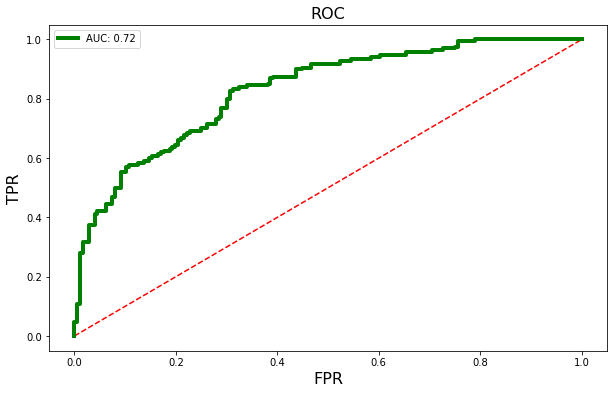

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize = (10, 6))
plt.plot([0,1], [0,1], 'r--') # dibujamos una diagonal que nos marcarán el comportamiento promedio

# calulamos la predicción de que la probabilidad sea 1 o 0 de los datos de prueba
probs = clf.predict_proba(X_test)

probs = probs[:, 1] # cogemos solo los que tenga probabilidad 1 (es lo que nos interesa ver)
# usamos la función roc_curve pasándole los 'y' de prueba y las probabilidades calculadas
fpr, tpr, thresholds = roc_curve(y_test,probs)
# calculamos la precision de nuestro modelo
roc_auc = roc_auc_score(y_test, y_test_hat)

label = 'AUC:' + ' {0:.2f}'.format(roc_auc)
# calculamos los parámetros necesarios
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('FPR', fontsize = 16)
plt.ylabel('TPR', fontsize = 16)
plt.title('ROC', fontsize = 16)
plt.legend();

Regla de dedo para un área bajo la curva en una curva ROC es:

- [0.5]: Equivalente a aleatorio.
- [0.5, 0.6): Test malo.
- [0.6, 0.75): Test regular.
- [0.75, 0.9): Test bueno.
- [0.9, 0.95): Test muy bueno.
- [0.95, 1): Muy bueno para ser cierto.

# Cumulative Accuracy Profile CAP

El perfil de precisión acumulativa o CAP se utiliza para visualizar el poder discriminativo de un modelo. El CAP de un modelo representa el número acumulado de resultados positivos a lo largo del eje y versus el número acumulado correspondiente de un parámetro de clasificación a lo largo del eje x.

In [16]:
# hacemos un muestre de 1000 elementos
df_cap = df.sample(1000,random_state=20)
cap_X = df_cap[['duration','age']]
df_cap.y.value_counts()
# vemos en el resultado que de cada 10, 1 dirá que 'si' y 9 que ' no'

0    900
1    100
Name: y, dtype: int64

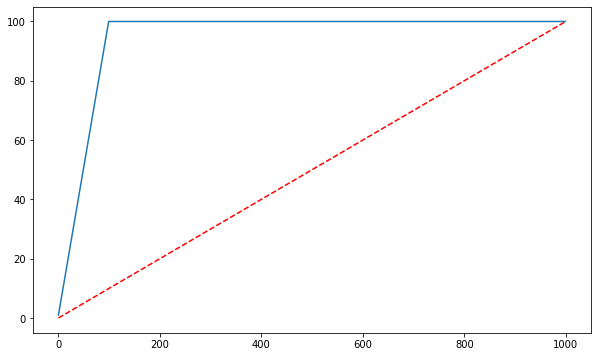

In [17]:
# vamos a visualizar lo anterior de una manera más intuitiva
df_cap = df.sample(1000,random_state=20)
cap_X = df_cap[['duration','age']]

# el eje 'x' nos dirá a cuantas personas hemos preguntado
# el eje 'y' nos dirá cuantas personas nos han dicho que 'si'

plt.figure(figsize = (10, 6))
plt.plot([0,1000], [0,100], 'r--');

# nuesto modelo CAP nos va a ayudar a que con nuestro modelo, si tener que
# preguntar al total de 1000 personas, podamos llegar al 100% de personas que
# respondieron que 'si'

# # -------------------------------------
# primero vamos a suponer un modelo perfecto:
# de 100 personas que preguntamos 100 responden que 'si'
# creamos entonces una matriz de 100 elementos de 1 con la función np.repeat y sumamos de manera acumulativa en el
# array perfect_model con np.cumsum
perfect_model = np.cumsum(np.repeat(1,100))
# redimensionamos nuestro array a otro con 1000 elementos
perfect_model.resize(1000)
perfect_model[100:] = 100
perfect_model
plt.plot(perfect_model);
# # -------------------------------------
# df_cap['probs'] = clf.predict_proba(cap_X)[:, 1]
# df_cap = df_cap.sort_values(by='probs',ascending=False)
# probs = np.cumsum(df_cap.y).values
# plt.plot(probs,c = 'g', label = label, linewidth = 4);
# # -------------------------------------
# plt.xlabel('Total de personas', fontsize = 16)
# plt.ylabel('Total de inversiones (casos si)', fontsize = 16)
# plt.title('CAP', fontsize = 16)
# # -------------------------------------
# plt.axvline(x=500, color='g', linestyle='--',alpha=0.5)
# plt.axhline(y=probs[499], color='g', linestyle='--',alpha=0.5)

# probs[499]

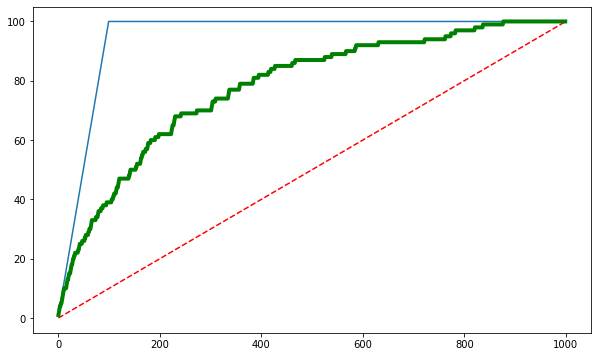

In [18]:
# vamos a visualizar lo anterior de una manera más intuitiva
df_cap = df.sample(1000,random_state=20)
cap_X = df_cap[['duration','age']]

# el eje 'x' nos dirá a cuantas personas hemos preguntado
# el eje 'y' nos dirá cuantas personas nos han dicho que 'si'

plt.figure(figsize = (10, 6))
plt.plot([0,1000], [0,100], 'r--');

# nuesto modelo CAP nos va a ayudar a que con nuestro modelo, si tener que
# preguntar al total de 1000 personas, podamos llegar al 100% de personas que
# respondieron que 'si'

# # -------------------------------------
# primero vamos a suponer un modelo perfecto:
# de 100 personas que preguntamos 100 responden que 'si'
perfect_model = np.cumsum(np.repeat(1,100))
perfect_model.resize(1000)
perfect_model[100:] = 100
perfect_model
plt.plot(perfect_model);
# # -------------------------------------
# ahora probamos que tal se está comportando nuestro modelo
# hacemos la prediccion de probabilidades con la curva CAP:
df_cap['probs'] = clf.predict_proba(cap_X)[:, 1] # probabilidades de nuestro comjunto de datos reducido cap_X y solo los
                                                # casos en que dijeron 'si'->[:,1]

# Ahora viene la diferencia con la curva ROC   
# ahora vamos a ordenar que persona es más probable que diga que 'si' y cual es la menos probable
df_cap = df_cap.sort_values(by='probs',ascending=False)
# suma acumulativa de las personas que dijeron 'si'
probs = np.cumsum(df_cap.y).values
plt.plot(probs,c = 'g', label = label, linewidth = 4);
# # -------------------------------------
# plt.xlabel('Total de personas', fontsize = 16)
# plt.ylabel('Total de inversiones (casos si)', fontsize = 16)
# plt.title('CAP', fontsize = 16)
# # -------------------------------------
# plt.axvline(x=500, color='g', linestyle='--',alpha=0.5)
# plt.axhline(y=probs[499], color='g', linestyle='--',alpha=0.5)

# probs[499]

87

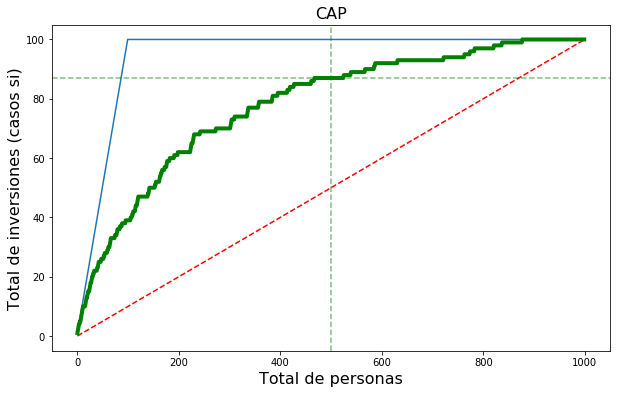

In [19]:
# vamos a visualizar lo anterior de una manera más intuitiva
df_cap = df.sample(1000,random_state=20)
cap_X = df_cap[['duration','age']]

# el eje 'x' nos dirá a cuantas personas hemos preguntado
# el eje 'y' nos dirá cuantas personas nos han dicho que 'si'

plt.figure(figsize = (10, 6))
plt.plot([0,1000], [0,100], 'r--');

# nuesto modelo CAP nos va a ayudar a que con nuestro modelo, si tener que
# preguntar al total de 1000 personas, podamos llegar al 100% de personas que
# respondieron que 'si'

# # -------------------------------------
# primero vamos a suponer un modelo perfecto:
# de 100 personas que preguntamos 100 responden que 'si'
perfect_model = np.cumsum(np.repeat(1,100))
perfect_model.resize(1000)
perfect_model[100:] = 100
perfect_model
plt.plot(perfect_model);
# # -------------------------------------
# ahora probamos que tal se está comportando nuestro modelo
# hacemos la prediccion de probabilidades con la curva CAP:
df_cap['probs'] = clf.predict_proba(cap_X)[:, 1] # probabilidades de nuestro comjunto de datos reducido cap_X y solo los
                                                # casos en que dijeron 'si'->[:,1]
    
# Ahora viene la diferencia con la curva ROC  
#ahora vamos a ordenar que persona es más probable que diga que 'si' y cual es la menos probable
df_cap = df_cap.sort_values(by='probs',ascending=False)
# suma acumulativa de las personas que dijeron 'si'
probs = np.cumsum(df_cap.y).values
plt.plot(probs,c = 'g', label = label, linewidth = 4);
# # -------------------------------------
# si contactamos con la mitad de personas,¿cuantas personas habrán dicho que 'si'?
plt.xlabel('Total de personas', fontsize = 16)
plt.ylabel('Total de inversiones (casos si)', fontsize = 16)
plt.title('CAP', fontsize = 16)
# indicamos la mitad de las personas trazando una línea vertical en x=500
plt.axvline(x=500, color='g', linestyle='--',alpha=0.5)
plt.axhline(y=probs[499], color='g', linestyle='--',alpha=0.5);

# vemos que si contactamos con la mitad de las personas obtenemos a 87 personas del total de 100 que ya habrían dicho
# que sí, con lo que ya no interesaría seguir preguntando a más personas.
probs[499]

- [0,0.6]: Equivalente a aleatorio o peor.
- [0.6, 0.7): Test malo.
- [0.7, 0.8): Test bueno.
- [0.8, 0.90): Test muy bueno.
- [0.90, 1): Muy bueno para ser cierto.

In [20]:
df_reduced.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3437,26,services,single,secondary,no,209,yes,no,cellular,22,jul,319,2,-1,0,unknown,0
4125,30,technician,married,secondary,no,-393,yes,yes,cellular,16,jul,435,1,-1,0,unknown,1
4416,32,blue-collar,single,secondary,no,811,yes,no,cellular,14,may,563,1,-1,0,unknown,1
1532,33,technician,married,secondary,no,133,no,no,cellular,4,may,218,1,-1,0,unknown,1
1017,49,blue-collar,married,secondary,no,-454,yes,no,cellular,14,may,558,1,-1,0,unknown,1


En general cuando construimos modelos predictivos, los métodos usados asumen que los datos son cuantitativos. Por ejemplo, variables como edad o saldo. En realidad, los datos pueden venir en forma categórica, por ejemplo, estado civil, genero, nivel de educación entre otros. Nosotros como científicos de datos podemos transformar los datos categóricos a numéricos para permitir a los algoritmos manejarlos más fácilmente pues recordemos que en realidad los modelos creados representan una función matemática.

Para ello tenemos dos alternativas:
 - Asignarles un valor numérico secuencial. Solo se puede utilizar cuando las categorías tienen un orden natural como por ejemplo el nivel de educación.
 - Utilizar variables ficticias o dummy.
 
 # Variables Dummy
 
Cuando construimos modelos predictivos los métodos usados asumen que los datos son cuantitativos aunque en realidad los datos pueden venir en forma categórica. Por ejemplo, estado civil, genero, nivel de educación, entre otros.

El científico de datos debe transformar los datos categóricos a numéricos para permitir a los algoritmos manejarlos más fácilmente, recordemos que los modelos representan una función matemática. Para resolver esta situación tenemos un concepto llamado variables ficticias o variables Dummy. 
 
Una variable ficticia es una variable artificial para representar una variable categórica con dos o más categorías.


In [21]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


In [22]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [23]:
# filtramos a traves de las varable tipo objeto
columns_to_dummy = df.columns[df.dtypes == np.object]
columns_to_dummy

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [24]:
# pasamos a dummy esas variables
df_w_dummy = pd.get_dummies(df,prefix=columns_to_dummy)
df_w_dummy.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,33,4789,11,220,1,339,4,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,35,1350,16,185,1,330,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,30,1476,3,199,4,-1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,59,0,5,226,1,-1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [25]:
df_w_dummy.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### Trampa de las variables ficticias

La trampa de las variables ficticias es un escenario en el cual dos o mas variables independientes son multicolineales, en términos más sencillos, es cuando con una variable podemos predecir la o las otras. La consecuencia de utilizar variables multicolineales es que nuestro modelo no pueda utilizar correctamente esa información. 


Para evitar caer en la trampa de la variable ficticia, una regla de dedo es utilizar una variable ficticia menos que el número de categorías.  Afortunadamente Python lo puede hacer de forma automática.


In [26]:
# quitamos la primera columna de los campos 'repetidos'
df_w_dummy = pd.get_dummies(df,prefix=columns_to_dummy,drop_first=True)
df_w_dummy.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,33,4789,11,220,1,339,4,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,35,1350,16,185,1,330,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,1476,3,199,4,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,59,0,5,226,1,-1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [27]:
df_w_dummy.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [28]:
# ya tenemos nuestros datos preparados para buscar nuestro mejor modelo


#UnderSampling
df_no = df_w_dummy[df_w_dummy['y'] == 0]
df_yes = df_w_dummy[df_w_dummy['y'] == 1]
df_no_reduced = df_no.sample(521,random_state=103)
df_reduced = pd.concat([df_no_reduced,df_yes],axis=0)
df_reduced = df_reduced.sample(frac=1,random_state=103)
# aqui como novedad le indicamos que en lugar de ver los datos como numeros enteros
# los pasaremos a flotantes para acelerar los calculos internos de python
df_reduced = df_reduced.astype('float')
df_reduced.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
3437,26.0,209.0,22.0,319.0,2.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4125,30.0,-393.0,16.0,435.0,1.0,-1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4416,32.0,811.0,14.0,563.0,1.0,-1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1532,33.0,133.0,4.0,218.0,1.0,-1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1017,49.0,-454.0,14.0,558.0,1.0,-1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


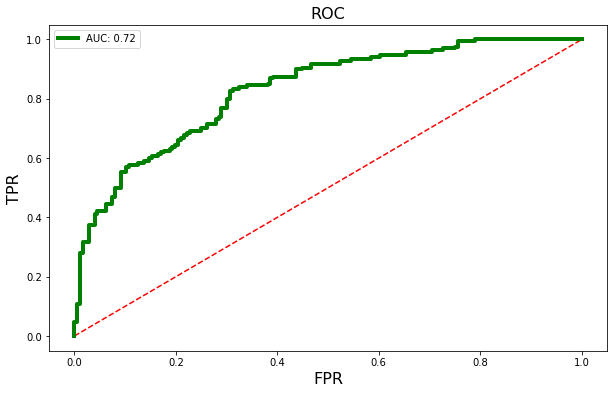

In [29]:
# Ejercicio

# Escogemos nuestras variables
X = df_reduced[['duration','age']]
y = df_reduced['y']

# Spliting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=103)

# Hacemos nuestro modelo de regresión logística y calculamos las predicción
clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)

# Realizamos una gráfica con una línea roja que marcará el límite inferior de nuestra área entre gráficas
plt.figure(figsize = (10, 6))
plt.plot([0,1], [0,1], 'r--')

# Dibujo la curva ROC
probs = clf.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,probs)
roc_auc = roc_auc_score(y_test, y_test_hat)
label = 'AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('FPR', fontsize = 16)
plt.ylabel('TPR', fontsize = 16)
plt.title('ROC', fontsize = 16)
plt.legend();

# Selección de características

Cuando un conjunto de datos tiene demasiadas características, algunas características pueden ser irrelevantes para la variable independiente. Entonces, utilizamos la selección de características para eliminar cualquier tipo de características innecesarias, irrelevantes o redundantes del conjunto de datos.

Las características irrelevantes no ayudarán a mejorar la precisión del modelo, en realidad podrían reducir la precisión de este, por lo que no nos interesa conservarlas en nuestro modelo de aprendizaje automático.

Una vez que ya tratamos con las variables categóricas, nos quedo un conjunto de datos con 43 variables. Seguramente algunas de ellas son completamente irrelevantes, es decir, no aportan nada o casi nada a nuestros modelos predictivos. Estas variables irrelevantes pueden dar problemas a nuestras estimaciones. Las variables irrelevantes:
- Desperdician memoria RAM.
- Actúan como ruido.
- Aumentan el tiempo de entrenamiento.

Una solución a este problema es la selección de características relevantes. Que es básicamente el proceso de seleccionar las variables o características más relevantes de un conjunto de datos. Hay básicamente tres tipos de métodos de selección de características:
- Métodos de filtrado: Son aquellos que utilizan medidas estadísticas para ordenar las variables por su significancia.
- Métodos de envoltura (grapping): Son aquellos que utilizan modelos predictivos para determinar la calidad de las variables seleccionadas.
- Métodos integrados: Son aquellos que incorporan el proceso de selección en la fase de entrenamiento del modelo predictivo. El ejemplo más común es el árbol de decisión.

La selección de métodos de envoltura, se realizan usualmente a manera de prueba y error y además de manera iterativa. Esta técnica se conoce como selección paso a paso o stepwise. 
Es importante recalcar que selección de características es diferente a la reducción de dimensionalidad. Aunque ambos métodos buscan reducir el número de características, la reducción de dimensionalidad lo hace transformando el conjunto de datos completo. Esto está fuera de las intenciones de este cuaderno, pero es bueno saber que existe una diferencia desde ahora.


In [30]:
# para acelerar nuestro entrenamiento escalamos nuestros datos entre 0 y 1
from sklearn.preprocessing import MinMaxScaler
X = df_reduced.drop("y",axis=1)
y = df_reduced.y
X_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=103)

In [60]:
df_reduced.shape

(1042, 43)

In [56]:
X.shape

(1042, 42)

In [57]:
y.shape

(1042, 1)

In [55]:
df_reduced.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
3437,26.0,209.0,22.0,319.0,2.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4125,30.0,-393.0,16.0,435.0,1.0,-1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4416,32.0,811.0,14.0,563.0,1.0,-1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1532,33.0,133.0,4.0,218.0,1.0,-1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1017,49.0,-454.0,14.0,558.0,1.0,-1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [59]:
# Recursive Feature Elimination o eliminacion de caracteristicas recursivas
from sklearn.feature_selection import RFE

# creamos nuestro modelo de estimacion
estimator = LogisticRegression(solver='lbfgs')
# le pasamos nuestro modelo de estimacion 
# el 8 es el número de variables finales que queremos
# 'step' es el número de variables a eliminar en cada iteracion
selector = RFE(estimator, 8, step=1)

selector = selector.fit(X_train, y_train.ravel()) #'.ravel()' equivalente a '.reshape(-1,1)'
# imprimimos un vector de soporte (support) y uno de ranking
# vemos que en el resultado de support hay 8 True, que coincide con el parámetro de
# variables finales que le pasamos.
print(selector.support_)
print(selector.ranking_)

[False False False  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False  True False False  True
  True  True False False  True False]
[10  8 28  1  1 27 11  5 30 13 23  3 22 35 21  9  4 34 18 19 24 29 26 33
 14 12 16  1 15 31 32  2  1 25  6  1  1  1 17 20  1  7]


In [53]:
df_reduced.shape

(1042, 43)

In [54]:
df_reduced.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
3437,26.0,209.0,22.0,319.0,2.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4125,30.0,-393.0,16.0,435.0,1.0,-1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4416,32.0,811.0,14.0,563.0,1.0,-1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1532,33.0,133.0,4.0,218.0,1.0,-1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1017,49.0,-454.0,14.0,558.0,1.0,-1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [61]:
# vamos a guardar esas 8 mejores variables en una funcion dandole el vector de soporte 'selector.support'
best_variables = selector.support_
# cogemos de nuestra dataframe reducido, las columnas de esas 8 mejores variables
df_reduced.drop("y",axis=1).loc[:, best_variables].head()

,duration,campaign,contact_unknown,month_jul,month_may,month_nov,month_oct,poutcome_success
3437,319.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
4125,435.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4416,563.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1532,218.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1017,558.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
# vamos a pasarle a nuestro modelo esa tabla de datos reducida con las 8 mejores variables

clf = LogisticRegression(solver='lbfgs').fit(X_train[:,best_variables], y_train.ravel())
y_test_hat = clf.predict(X_test[:,best_variables])

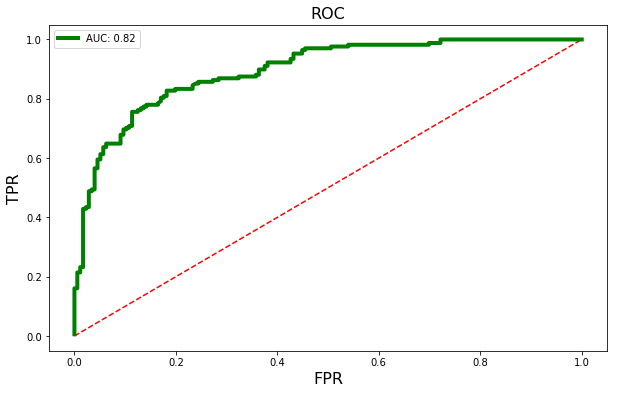

In [25]:
plt.figure(figsize = (10, 6))
plt.plot([0,1], [0,1], 'r--')

probs = clf.predict_proba(X_test[:,best_variables])
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,probs)
roc_auc = roc_auc_score(y_test, y_test_hat)
label = 'AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('FPR', fontsize = 16)
plt.ylabel('TPR', fontsize = 16)
plt.title('ROC', fontsize = 16)
plt.legend();